<a href="https://colab.research.google.com/github/zhrnnsw/Machine-Learning/blob/main/week-10/Praktikum%20Pertemuan%2010.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Laporan Praktikum Pertemuan 10 - Recurrent Neural Network (RNN)**
---


> Nama: Zahra Annisa Wahono
>
> Kelas: TI-3H / 29
>
> NIM: 2141720016

## **Praktikum 1 - RNN untuk Analisis Sentimen**

### **Setup**

Impor matplotlib dan buat fungsi pembantu untuk memplot grafik:

In [1]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

In [2]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

### **Setup input pipeline**

Dataset ulasan film IMDB adalah kumpulan data klasifikasi biner—semua ulasan memiliki sentimen positif atau negatif.
Download dataset menggunakan TFDS. Lihat loading text tutorial jika ingin me load data secara manual

In [3]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

Awalnya ini mengembalikan dataset (teks, pasangan label):

In [4]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


Berikutnya acak data untuk pelatihan dan membuat kumpulan pasangan (teks, label) ini:

In [5]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])


texts:  [b"hi, im scott (A.K.A woody7739) i Love the film Twisted Desire, And i love watching Melissa Joan Hart on the t.v as i think she is fine. I am a real fan of sabrina the teenage witch too, so this helped my watch it (don't ask). i love the way that nicole plans out her parents murder very carfully, as she makes sure that someone else pulls the trigger and practices on the bottles, so she wont give away her fingerprints (a very well planned out idea), back i guess it all backfired on nicole as she got caught as her old boyfriend comes along and puts a hidden camera under his shirt. i give this film a nine out of ten, and put it in MY top 10 films list. And last but not least if anyone see's this film in the shops please tell me as i seen it on tv and didn't record it. bye"
 b'I saw this film last night (about 102 minutes) and don\'t know what kept me in my seat. I guess I just expected a film with Gere would have some value in it eventually but nothing of value ever came on the 

### **Buat Teks Encoder**

Teks mentah yang dimuat oleh tfds perlu diproses sebelum dapat digunakan dalam model. Cara termudah memproses teks untuk pelatihan adalah menggunakan lapisan TextVectorization. Lapisan ini memiliki banyak kemampuan, namun pada tutorial ini menggunakan perilaku default. Buat lapisan tersebut, dan teruskan teks kumpulan data ke metode .adapt lapisan:

In [6]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

Metode .adapt mengatur kosakata lapisan. 20 token pertama dapat dilihat dengan kode berikut. Setelah padding dan token yang tidak diketahui, mereka diurutkan berdasarkan frekuensi:

In [7]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

Setelah kosakata diatur, lapisan dapat mengkodekan teks ke dalam indeks. Tensor indeks diberi bantalan 0 ke urutan terpanjang dalam batch (kecuali jika Anda menetapkan output_sequence_length tetap):

In [8]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[  1, 142,   1, ...,   0,   0,   0],
       [ 10, 208,  11, ...,   0,   0,   0],
       [ 11,  18,  44, ...,   0,   0,   0]])

Dengan pengaturan default, prosesnya tidak dapat dibalik sepenuhnya. Ada dua alasan utama untuk itu:
-Nilai default untuk argumen standarisasi preprocessing.TextVectorization adalah "lower_and_strip_punctuation".
-Ukuran kosa kata yang terbatas dan kurangnya fallback berbasis karakter menghasilkan beberapa token yang tidak diketahui.

In [9]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b"hi, im scott (A.K.A woody7739) i Love the film Twisted Desire, And i love watching Melissa Joan Hart on the t.v as i think she is fine. I am a real fan of sabrina the teenage witch too, so this helped my watch it (don't ask). i love the way that nicole plans out her parents murder very carfully, as she makes sure that someone else pulls the trigger and practices on the bottles, so she wont give away her fingerprints (a very well planned out idea), back i guess it all backfired on nicole as she got caught as her old boyfriend comes along and puts a hidden camera under his shirt. i give this film a nine out of ten, and put it in MY top 10 films list. And last but not least if anyone see's this film in the shops please tell me as i seen it on tv and didn't record it. bye"
Round-trip:  [UNK] im [UNK] [UNK] [UNK] i love the film [UNK] [UNK] and i love watching [UNK] [UNK] [UNK] on the tv as i think she is fine i am a real fan of [UNK] the [UNK] [UNK] too so this [UNK] my watch 

### **Buat Model**

In [10]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [11]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [12]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 7s 7s/step
[-0.01134945]


In [13]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

1/1 [==============================] - 0s 67ms/step
[-0.01134945]


In [14]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

### **Train Model**

In [15]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 52s 107ms/step - loss: 0.6363 - accuracy: 0.5697 - val_loss: 0.4980 - val_accuracy: 0.7693
Epoch 2/10
391/391 [==============================] - 26s 65ms/step - loss: 0.4136 - accuracy: 0.8122 - val_loss: 0.3955 - val_accuracy: 0.8427
Epoch 3/10
391/391 [==============================] - 26s 65ms/step - loss: 0.3451 - accuracy: 0.8462 - val_loss: 0.3525 - val_accuracy: 0.8354
Epoch 4/10
391/391 [==============================] - 25s 63ms/step - loss: 0.3238 - accuracy: 0.8596 - val_loss: 0.3333 - val_accuracy: 0.8469
Epoch 5/10
391/391 [==============================] - 25s 62ms/step - loss: 0.3120 - accuracy: 0.8655 - val_loss: 0.3389 - val_accuracy: 0.8443
Epoch 6/10
391/391 [==============================] - 24s 62ms/step - loss: 0.3082 - accuracy: 0.8675 - val_loss: 0.3259 - val_accuracy: 0.8583
Epoch 7/10
391/391 [==============================] - 25s 64ms/step - loss: 0.3010 - accuracy: 0.8710 - val_loss: 0.3203 - val_accuracy

In [16]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 12s 30ms/step - loss: 0.3137 - accuracy: 0.8588
Test Loss: 0.3137408494949341
Test Accuracy: 0.8588399887084961


(0.0, 0.6534425526857376)

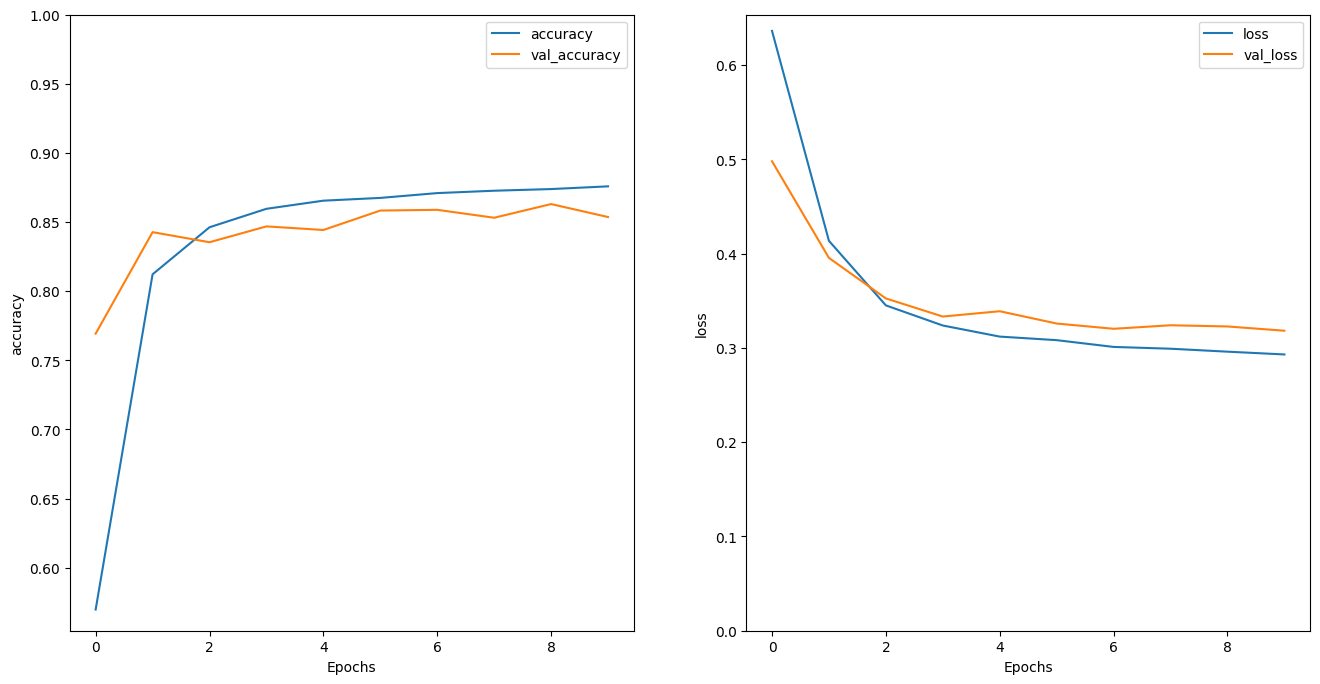

In [17]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [18]:
sample_text = ('The movie was cool. The animation and the graphics '
                'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

1/1 [==============================] - 3s 3s/step


### **Stack two or more LSTM layers**

In [20]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [21]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [22]:
history = model.fit(train_dataset, epochs=10,
                     validation_data=test_dataset,
                     validation_steps=30)

Epoch 1/10
391/391 [==============================] - 90s 183ms/step - loss: 0.6322 - accuracy: 0.5809 - val_loss: 0.4483 - val_accuracy: 0.7792
Epoch 2/10
391/391 [==============================] - 46s 117ms/step - loss: 0.3894 - accuracy: 0.8275 - val_loss: 0.3562 - val_accuracy: 0.8443
Epoch 3/10
391/391 [==============================] - 47s 118ms/step - loss: 0.3417 - accuracy: 0.8557 - val_loss: 0.3335 - val_accuracy: 0.8443
Epoch 4/10
391/391 [==============================] - 46s 117ms/step - loss: 0.3228 - accuracy: 0.8626 - val_loss: 0.3571 - val_accuracy: 0.8557
Epoch 5/10
391/391 [==============================] - 46s 118ms/step - loss: 0.3141 - accuracy: 0.8668 - val_loss: 0.3216 - val_accuracy: 0.8583
Epoch 6/10
391/391 [==============================] - 47s 119ms/step - loss: 0.3093 - accuracy: 0.8690 - val_loss: 0.3207 - val_accuracy: 0.8604
Epoch 7/10
391/391 [==============================] - 46s 117ms/step - loss: 0.3035 - accuracy: 0.8708 - val_loss: 0.3182 - val_ac

In [23]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 20s 50ms/step - loss: 0.3140 - accuracy: 0.8602
Test Loss: 0.3140273690223694
Test Accuracy: 0.8602399826049805


In [24]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
                'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

1/1 [==============================] - 5s 5s/step
[[-2.2090652]]


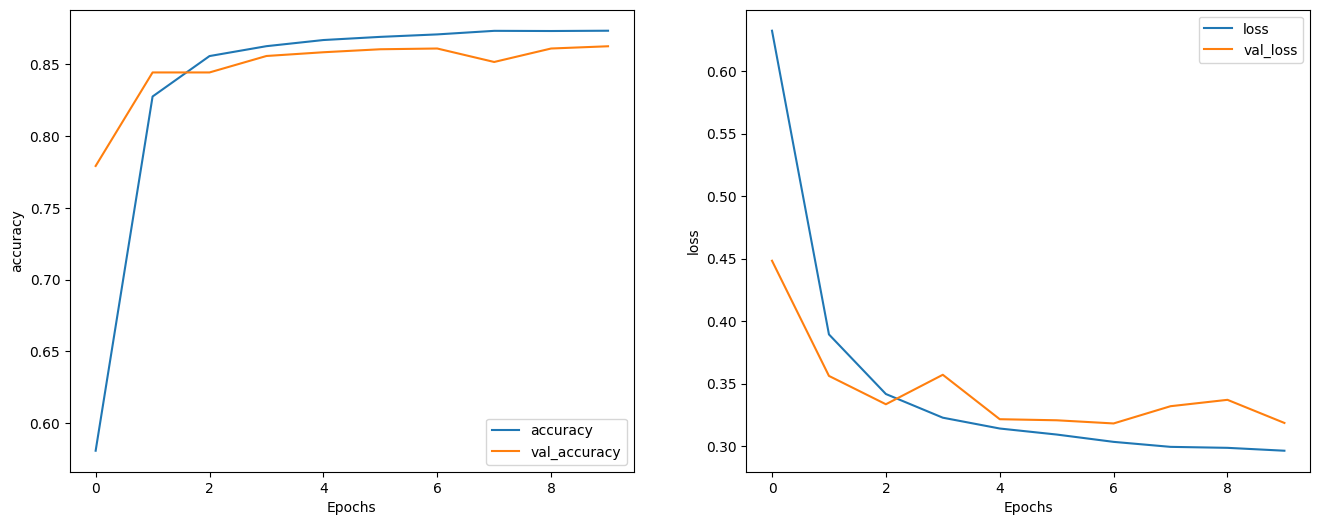

In [25]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

## **Praktikum 2 - Generator Teks dengan RNN**

### **Setup**

In [26]:
import tensorflow as tf
import numpy as np
import os
import time

In [27]:
path_to_file = tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')

1115394/1115394 [==============================] - 0s 0us/step


### **Load Data**

In [28]:
# Read, then decode for py2 compat.
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
# length of text is the number of characters in it
print(f'Length of text: {len(text)} characters')

Length of text: 1115394 characters


In [29]:
# Take a look at the first 250 characters in text
print(text[:250])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.



In [30]:
# The unique characters in the file
vocab = sorted(set(text))
print(f'{len(vocab)} unique characters')

65 unique characters


### **Olah Teks**

In [31]:
example_texts = ['abcdefg', 'xyz']
chars = tf.strings.unicode_split(example_texts, input_encoding='UTF-8')
chars

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

In [32]:
ids_from_chars = tf.keras.layers.StringLookup(
vocabulary=list(vocab), mask_token=None)

In [33]:
ids = ids_from_chars(chars)
ids

<tf.RaggedTensor [[40, 41, 42, 43, 44, 45, 46], [63, 64, 65]]>

In [34]:
chars_from_ids = tf.keras.layers.StringLookup(
    vocabulary=ids_from_chars.get_vocabulary(), invert=True, mask_token=None)

In [35]:
chars = chars_from_ids(ids)
chars

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

In [36]:
tf.strings.reduce_join(chars, axis=-1).numpy()

array([b'abcdefg', b'xyz'], dtype=object)

In [37]:
def text_from_ids(ids):
    return tf.strings.reduce_join(chars_from_ids(ids), axis=-1)

### **Prediksi**

In [38]:
all_ids = ids_from_chars(tf.strings.unicode_split(text,'UTF-8'))
all_ids

<tf.Tensor: shape=(1115394,), dtype=int64, numpy=array([19, 48, 57, ..., 46,  9,  1])>

In [39]:
ids_dataset =tf.data.Dataset.from_tensor_slices(all_ids)

In [40]:
for ids in ids_dataset.take(10):
    print(chars_from_ids(ids).numpy().decode('utf-8'))

F
i
r
s
t
 
C
i
t
i


In [41]:
seq_length = 100

In [42]:
sequences = ids_dataset.batch(seq_length+1, drop_remainder=True)

for seq in sequences.take(1):
  print(chars_from_ids(seq))

tf.Tensor(
[b'F' b'i' b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':'
 b'\n' b'B' b'e' b'f' b'o' b'r' b'e' b' ' b'w' b'e' b' ' b'p' b'r' b'o'
 b'c' b'e' b'e' b'd' b' ' b'a' b'n' b'y' b' ' b'f' b'u' b'r' b't' b'h'
 b'e' b'r' b',' b' ' b'h' b'e' b'a' b'r' b' ' b'm' b'e' b' ' b's' b'p'
 b'e' b'a' b'k' b'.' b'\n' b'\n' b'A' b'l' b'l' b':' b'\n' b'S' b'p' b'e'
 b'a' b'k' b',' b' ' b's' b'p' b'e' b'a' b'k' b'.' b'\n' b'\n' b'F' b'i'
 b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':' b'\n' b'Y'
 b'o' b'u' b' '], shape=(101,), dtype=string)


In [43]:
for seq in sequences.take(5):
    print(text_from_ids(seq).numpy())

b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '
b'are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you k'
b"now Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us ki"
b"ll him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it be d"
b'one: away, away!\n\nSecond Citizen:\nOne word, good citizens.\n\nFirst Citizen:\nWe are accounted poor citi'


In [44]:
def split_input_target(sequence):
    input_text = sequence[:-1]
    target_text = sequence[1:]
    return input_text, target_text

In [45]:
split_input_target(list("Tensorflow"))

(['T', 'e', 'n', 's', 'o', 'r', 'f', 'l', 'o'],
 ['e', 'n', 's', 'o', 'r', 'f', 'l', 'o', 'w'])

In [46]:
dataset = sequences.map(split_input_target)

In [47]:
for input_example, target_example in dataset.take(1):
    print("Input :", text_from_ids(input_example).numpy())
    print("Target:", text_from_ids(target_example).numpy())

Input : b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'
Target: b'irst Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '


### **Membuat Batch Training**

In [48]:
# Batch size
BATCH_SIZE = 64

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(64, 100), dtype=tf.int64, name=None), TensorSpec(shape=(64, 100), dtype=tf.int64, name=None))>

### **Buat Model**

In [49]:
# Length of the vocabulary in StringLookup Layer
vocab_size = len(ids_from_chars.get_vocabulary())

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

In [50]:
class MyModel(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(rnn_units,
                                   return_sequences=True,
                                   return_state=True)
    self.dense = tf.keras.layers.Dense(vocab_size)

  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training)
    if states is None:
      states = self.gru.get_initial_state(x)
    x, states = self.gru(x, initial_state=states, training=training)
    x = self.dense(x, training=training)

    if return_state:
      return x, states
    else:
      return x

In [51]:
model = MyModel(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

### **Uji Model**

In [52]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 100, 66) # (batch_size, sequence_length, vocab_size)


In [53]:
model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     multiple                  16896     
                                                                 
 gru (GRU)                   multiple                  3938304   
                                                                 
 dense_4 (Dense)             multiple                  67650     
                                                                 
Total params: 4022850 (15.35 MB)
Trainable params: 4022850 (15.35 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [56]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices, axis=-1).numpy()

In [57]:
sampled_indices

array([20, 38, 20, 54, 10, 61, 37,  7, 23, 63, 30, 43, 15, 58, 29,  9, 53,
        2, 45, 63, 45, 11, 16, 22, 23, 12, 51, 50,  1, 38, 63, 45,  3, 27,
       47, 27, 34, 42,  1, 10, 18, 26, 20, 28, 41, 52,  1, 26, 26, 60, 10,
       10,  4, 37, 38, 58, 28, 59, 21, 35,  3, 15,  6, 34, 27,  8, 52, 43,
        0, 58, 42, 58, 21, 59, 42, 47, 42, 63, 43, 41, 33, 19, 14, 37, 50,
       45, 31, 27, 53, 18, 37, 34, 52, 62, 14, 37, 13, 31, 38, 54])

In [58]:
print("Input:\n", text_from_ids(input_example_batch[0]).numpy())
print()
print("Next Char Predictions:\n",text_from_ids(sampled_indices).numpy())

Input:
 b' a horse-drench. Is he\nnot wounded? he was wont to come home wounded.\n\nVIRGILIA:\nO, no, no, no.\n\nVOL'

Next Char Predictions:
 b"GYGo3vX,JxQdBsP.n fxf:CIJ;lk\nYxf!NhNUc\n3EMGObm\nMMu33$XYsOtHV!B'UN-md[UNK]scsHtchcxdbTFAXkfRNnEXUmwAX?RYo"


### **Train Model**

In [59]:
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

In [60]:
example_batch_mean_loss = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("Mean loss:        ", example_batch_mean_loss)

Prediction shape:  (64, 100, 66)  # (batch_size, sequence_length, vocab_size)
Mean loss:         tf.Tensor(4.190209, shape=(), dtype=float32)


In [61]:
tf.exp(example_batch_mean_loss).numpy()

66.03658

In [62]:
model.compile(optimizer='adam',loss=loss)

In [63]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

In [64]:
EPOCHS = 20

In [65]:
history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

Epoch 1/20
172/172 [==============================] - 16s 57ms/step - loss: 2.7293
Epoch 2/20
172/172 [==============================] - 12s 55ms/step - loss: 1.9933
Epoch 3/20
172/172 [==============================] - 11s 56ms/step - loss: 1.7140
Epoch 4/20
172/172 [==============================] - 11s 56ms/step - loss: 1.5538
Epoch 5/20
172/172 [==============================] - 11s 57ms/step - loss: 1.4549
Epoch 6/20
172/172 [==============================] - 11s 57ms/step - loss: 1.3860
Epoch 7/20
172/172 [==============================] - 12s 57ms/step - loss: 1.3334
Epoch 8/20
172/172 [==============================] - 12s 58ms/step - loss: 1.2893
Epoch 9/20
172/172 [==============================] - 11s 58ms/step - loss: 1.2489
Epoch 10/20
172/172 [==============================] - 12s 58ms/step - loss: 1.2104
Epoch 11/20
172/172 [==============================] - 12s 57ms/step - loss: 1.1712
Epoch 12/20
172/172 [==============================] - 12s 58ms/step - loss: 1.1307
E

### **Generate Teks**

In [66]:
class OneStep(tf.keras.Model):
  def __init__(self, model, chars_from_ids, ids_from_chars, temperature=1.0):
    super().__init__()
    self.temperature = temperature
    self.model = model
    self.chars_from_ids = chars_from_ids
    self.ids_from_chars = ids_from_chars

    # Create a mask to prevent "[UNK]" from being generated.
    skip_ids = self.ids_from_chars(['[UNK]'])[:, None]
    sparse_mask = tf.SparseTensor(
        # Put a -inf at each bad index.
        values=[-float('inf')]*len(skip_ids),
        indices=skip_ids,
        # Match the shape to the vocabulary
        dense_shape=[len(ids_from_chars.get_vocabulary())])
    self.prediction_mask = tf.sparse.to_dense(sparse_mask)

  @tf.function
  def generate_one_step(self, inputs, states=None):
    # Convert strings to token IDs.
    input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
    input_ids = self.ids_from_chars(input_chars).to_tensor()

    # Run the model.
    # predicted_logits.shape is [batch, char, next_char_logits]
    predicted_logits, states = self.model(inputs=input_ids, states=states,
                                          return_state=True)
    # Only use the last prediction.
    predicted_logits = predicted_logits[:, -1, :]
    predicted_logits = predicted_logits/self.temperature
    # Apply the prediction mask: prevent "[UNK]" from being generated.
    predicted_logits = predicted_logits + self.prediction_mask

    # Sample the output logits to generate token IDs.
    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
    predicted_ids = tf.squeeze(predicted_ids, axis=-1)

    # Convert from token ids to characters
    predicted_chars = self.chars_from_ids(predicted_ids)

    # Return the characters and model state.
    return predicted_chars, states

In [68]:
one_step_model = OneStep(model, chars_from_ids, ids_from_chars)

In [69]:
start = time.time()
states = None
next_char = tf.constant(['ROMEO:'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)
print('\nRun time:', end - start)

ROMEO:
Go more, Lancaster?

Nurse:
What's this?

JULIET:
I pray you all the scene you are behelds.

HENRY GOLINE:
He will eat at this that I cersan.

LEONTES:
Stand not
Now we'll fest in perfect love indeed and
send for our here tombries in'd.

GRUMIO:
You give me toward: he in the absence of these senses
Old wish the crush and time will have a touch of eyes.

KING RICHARD II:
Come, be gone, you give me one by me;
his call advancemned pattern, or else a groan
Apoint to hide years of what myself have
laid in absence. To your hand,
Thou weep'st me in his land was done with the happy phed
so? if you were born best you at my memory.

LORDSS:
He's sent a fellow; but of a gloring favour
Would you be seen.

First Citizen:
Come, coward! O woful tauchel people shows, but as a nuch
despair no ligit to the matter: the wish
We should eyes, calling but a deal too,
Who is tos that banish'd Henry lies in free,
Which once thou canst always but ever unstone that speak;
And see him save the broken healt

In [70]:
start = time.time()
states = None
next_char = tf.constant(['ROMEO:', 'ROMEO:', 'ROMEO:', 'ROMEO:', 'ROMEO:'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result, '\n\n' + '_'*80)
print('\nRun time:', end - start)

tf.Tensor(
[b"ROMEO:\nWhat is that will I was here? Where is that tomb'd that?\n\nBRUTUS:\nWhile weNe my woes can sent\nThe proud tedious I attle sens.\nIt is not so good deed; no doubt, sir.\n\nLADY ANNE:\nWho gives not so, or love me that the east news.\n\nFRIAR PETER:\nBlind from my husband, yet my Lord Kates in the mine.\n\nEXTON:\nGrank'st thy effect any of your knees, and more, how buy forced?\nIf thou hadst cush out your person pound at speech\nThat spirit, madam, between me up host and\nso by that hoped.\n\nBIONDELLO:\nFaith, no honest and obher, dear sir,\nRefuss his free spleck for, as yourself settled,\nIf not, my lord, the king's soon give the people\nAnd that all speed to Bennother; no more.\n\nCORIOLANUS:\nI would he cannot be married. What from my lovely queen,\nHevevary and Warwick or objects?\nFor faith have loved my brother hath.\n\nLADY ANNE:\nHow dost thou every chamber? knew not how to God please you,\niccling it well. But thou shouldst be hewn up,\nOr, if our peop

### **Ekspor Model Generator**

In [71]:
tf.saved_model.save(one_step_model, 'one_step')
one_step_reloaded = tf.saved_model.load('one_step')

In [72]:
states = None
next_char = tf.constant(['ROMEO:'])
result = [next_char]

for n in range(100):
  next_char, states = one_step_reloaded.generate_one_step(next_char, states=states)
  result.append(next_char)

print(tf.strings.join(result)[0].numpy().decode("utf-8"))

ROMEO:
What were you good?

Moster:
If ever I like near ye;
Tear to this very trick upon the way our books


## **Tugas**